Rented Bike Count - Upper outliers:
 2946    2401
2994    2402
3114    2401
3210    2404
3282    2692
        ... 
7746    2631
7818    2613
7842    2415
7866    2612
7890    2632
Name: Rented Bike Count, Length: 158, dtype: int64


KeyError: "None of [Index(['Wind speed (m/s)'], dtype='object')] are in the [columns]"

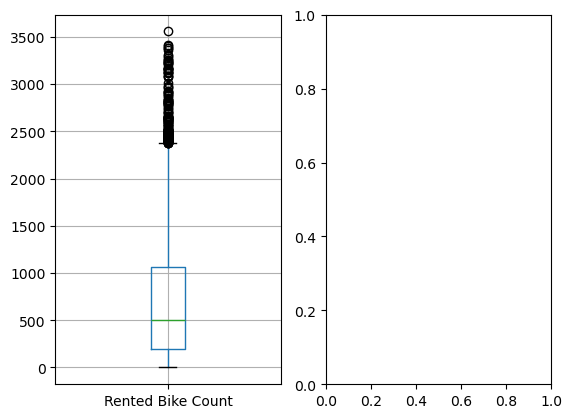

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def findMinMax(data):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)
  min = q1 - 1.5 * (q3 - q1)
  max = q3 + 1.5 * (q3 - q1)
  return min, max

# Function to help us visualize the outliers. Produce boxplot and print out outliers
def getOutliers(data, features):
  for i, feature in enumerate(features, 1):
    plt.subplot(1,len(features),i)
    data[[feature]].boxplot()
    
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    if outliers_lower.any():
      print(feature, "- Lower outliers:\n", data.loc[outliers_lower, feature])
    if outliers_upper.any():
      print(feature, "- Upper outliers:\n", data.loc[outliers_upper, feature])

  plt.show()
  

# return az set of data with outliers removed
def removeOutliers(data, features):
  removeIdx = pd.Series([False] * len(data))
  for i, feature in enumerate(features):
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    removeIdx = removeIdx | outliers_lower | outliers_upper

  return data.loc[~removeIdx]
  


# Testing code
data = pd.DataFrame(pd.read_csv('./SeoulBikeData.csv'))
features = ['Rented Bike Count', 'Wind speed (m/s)']

getOutliers(data, features)

newData = removeOutliers(data, features)
getOutliers(newData, features)

Rented Bike Count - Upper outliers:
 2946    2401
2994    2402
3114    2401
3210    2404
3282    2692
        ... 
7746    2631
7818    2613
7842    2415
7866    2612
7890    2632
Name: Rented Bike Count, Length: 152, dtype: int64
Wind speed - Upper outliers:
 82      4.5
84      4.8
85      5.4
86      4.5
87      5.8
       ... 
7932    4.9
7933    4.6
7934    4.4
7937    5.7
7985    4.9
Name: Wind speed, Length: 154, dtype: float64
Solar Radiation - Upper outliers:
 1741    2.35
1885    2.46
1886    2.39
1982    2.49
2054    2.36
        ... 
7741    2.43
7764    2.37
7765    2.45
7788    2.33
7789    2.40
Name: Solar Radiation, Length: 620, dtype: float64
Rainfall - Upper outliers:
 51       0.5
54       1.0
57       2.5
78       0.1
120      0.1
        ... 
8229    18.0
8520     0.2
8523     1.0
8601     9.1
8604     1.8
Name: Rainfall, Length: 516, dtype: float64
Snowfall - Upper outliers:
 120     0.1
121     0.3
122     0.4
123     0.4
124     0.4
       ... 
8645    0.3
8646 

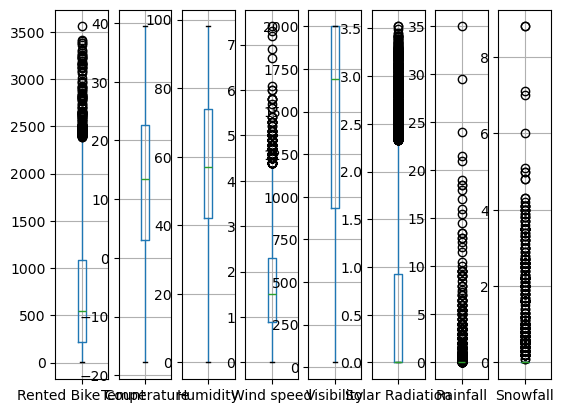

      Rented Bike Count  Hour  Temperature  Humidity  Wind speed  Visibility  \
0                   254     0         -5.2        37         2.2        2000   
1                   204     1         -5.5        38         0.8        2000   
2                   173     2         -6.0        39         1.0        2000   
3                   107     3         -6.2        40         0.9        2000   
4                    78     4         -6.0        36         2.3        2000   
...                 ...   ...          ...       ...         ...         ...   
8154               1003    19          4.2        34         2.6        1894   
8155                764    20          3.4        37         2.3        2000   
8156                694    21          2.6        39         0.3        1968   
8157                712    22          2.1        41         1.0        1859   
8158                584    23          1.9        43         1.3        1909   

      Solar Radiation  Rainfall  Snowfa

In [5]:
from sklearn.preprocessing import StandardScaler

data = pd.DataFrame(pd.read_csv('./SeoulBikeData.csv'))

# Remove rows with non-functioning day / no bike rented
functioningDay = data['Functioning Day'] == 'Yes'
data = data.loc[functioningDay]

# Dropping some features:
# Date: can't process and we already have the holiday feature
# Dew temp: not relevant
# Functioning day: already process
data = data.drop(columns=['Date', 'Dew point temperature', 'Functioning Day'])


# One Hot Encode categorical features
# Hour should be categorical too. Not sure how to handle it yet
data = pd.get_dummies(data, columns=['Seasons'], dtype=int)
data = pd.get_dummies(data, columns=['Holiday'], dtype=int, drop_first=True)


getOutliers(data, ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall'])

# It seems like every rainy or snowy days are counted as outliers because the weather is normal most of the time.
# Therefore, not going to remove outliers for Rainfall and Snowfall

# A lot of outliers for Solar Radiation. We can test this out with our models. For now, not removing outliers for this one

# Around 150 outliers for Rented Bike Count and Wind Speed. Remove outliers for now

data = removeOutliers(data, ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility'])
data = data.reset_index(drop=True)
print(data)


# Splitting data between categorical and numericals set for standardization
categoricalFeatures = ['Hour', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Holiday_No Holiday']
numericalFeatures = ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall']
categoricalValues = data[categoricalFeatures]
standardizedData = data.drop(columns=categoricalFeatures)

scaler = StandardScaler()
scaler.fit(standardizedData)
standardizedData = scaler.transform(standardizedData)
standardizedData = pd.DataFrame(standardizedData)
standardizedData.columns = numericalFeatures

standardizedData = pd.concat([standardizedData, categoricalValues], axis=1)
print(standardizedData)

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# helper function to calculate MSE with L2 regularization
def calc_l2_mse(X, y, weights, reg_parameter):
    predictions = np.dot(X, weights)
    mse = np.mean((predictions - y) ** 2)
    l2_penalty = (reg_parameter/(2*len(y))) * np.sum(weights ** 2)

    return mse + l2_penalty

# Note, need to modify X as appropriate for the different types of regression by adding column of 1's or any other parameters as neccessary
def grid_search_bgd(X, y, folds=10, test_size=0.25, 
                     batch_sizes=[16, 32, 64],
                     learning_rates =[.001, 0.01], 
                     reg_parameters=[0.0001, 0.001, 0.01]):
    # need to convert to numpy arrays for compatibility w sklearn
    X_np = X.to_numpy()
    y_np = y.to_numpy()
    
    # Initialize variables to track best model
    best_mse = float('inf')
    best_model = None
    results = []

    # create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias = false)
    X_poly = poly.fit_transform(X)

    # Features should already be standardized though?
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X_poly)

    kf = KFold(folds, random_state=42)


    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for reg_para in reg_parameters:
                # Store MSEs for this configuration, save across models
                fold_mses = []
                
                # Perform cross-validation
                for train_index, test_index in kf.split(X_poly):
                    # Split data into training and testing sets for this fold
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
            
                    # custom batch gradient descent function with L2 aka ridge regression
                    weights, bias, loss_history = bgd(
                        X_train, y_train,
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        reg_para=reg_para,
                        epochs=100
                    )
                    y_pred = predict_batch_gd(X_test)

                    # Calculate MSE for new model prediction
                    mse = mean_squared_error(y_pred, y_test)
                    fold_mses.append(mse)

                # avg mean across the folds for curr degree and alpha
                avg_mse = np.mean(fold_mses)
            
                # Updating the best model if current is better
                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_model = model
                    best_degree = degree
                    best_alpha = alpha
        
    # print the total_error of the best model
    min_error_index = np.argmin(mses)
    best_model = models[min_error_index]
    mse = mses[min_error_index]
    
    print(f"Best Degree: {best_degree}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best Mean Squared Error: {best_mse}")
    
    return best_model, best_degree, best_alpha

# Testing Code



In [1]:
# data will be from previous cell after it is run
X = data.drop('Rented Bike Count', axis=1)
y = data['Rented Bike Count']
folds = 10 # k number folds

best_model, best_degree, best_alpha = perform_training(X,y,folds)


NameError: name 'pd' is not defined